In [1]:
# Imports for Diabetes XGBoost Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder

# XGBoost
import xgboost as xgb

# Optuna for tuning
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# SHAP for explainability
import shap

# Save models
import joblib
import json

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries loaded!")
print("📊 Building: Diabetes Prediction Model")
print("📁 Dataset: 100,000 patients")

✅ All libraries loaded!
📊 Building: Diabetes Prediction Model
📁 Dataset: 100,000 patients


In [2]:
# Load the diabetes dataset with engineered features
diabetes_df = pd.read_csv('../data/processed/diabetes_featured.csv')

print("✅ Diabetes data loaded!")
print(f"Shape: {diabetes_df.shape}")
print(f"Patients: {diabetes_df.shape[0]:,}")
print(f"Features: {diabetes_df.shape[1]}")

# Quick look at columns
print(f"\nColumns:")
for i, col in enumerate(diabetes_df.columns, 1):
    print(f"  {i}. {col}")

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/diabetes_featured.csv'

In [3]:
# Check what files exist in processed folder
import os

processed_path = '../data/processed/'

if os.path.exists(processed_path):
    files = os.listdir(processed_path)
    print("📁 Files in data/processed/:")
    for f in files:
        print(f"  - {f}")
else:
    print("❌ Processed folder doesn't exist!")
    
# Also check raw data folder
raw_path = '../data/raw/'
if os.path.exists(raw_path):
    files = os.listdir(raw_path)
    print("\n📁 Files in data/raw/:")
    for f in files:
        print(f"  - {f}")

📁 Files in data/processed/:
  - .DS_Store
  - images
  - tabular

📁 Files in data/raw/:
  - images
  - tabular


In [4]:
# Check inside tabular folders
processed_tabular = '../data/processed/tabular/'
raw_tabular = '../data/raw/tabula/'

if os.path.exists(processed_tabular):
    files = os.listdir(processed_tabular)
    print("📁 Files in data/processed/tabular/:")
    for f in files:
        print(f"  - {f}")

if os.path.exists(raw_tabular):
    files = os.listdir(raw_tabular)
    print("\n📁 Files in data/raw/tabula/:")
    for f in files:
        print(f"  - {f}")
        

📁 Files in data/processed/tabular/:
  - diabetes_features.csv
  - heart_features.csv


In [5]:
# Load the diabetes dataset with engineered features
diabetes_df = pd.read_csv('../data/processed/tabular/diabetes_features.csv')

print("✅ Diabetes data loaded!")
print(f"Shape: {diabetes_df.shape}")
print(f"Patients: {diabetes_df.shape[0]:,}")
print(f"Features: {diabetes_df.shape[1]}")

# Quick look at columns
print(f"\nColumns:")
for i, col in enumerate(diabetes_df.columns, 1):
    print(f"  {i}. {col}")

✅ Diabetes data loaded!
Shape: (100000, 24)
Patients: 100,000
Features: 24

Columns:
  1. gender
  2. age
  3. hypertension
  4. heart_disease
  5. smoking_history
  6. bmi
  7. HbA1c_level
  8. blood_glucose_level
  9. diabetes
  10. gender_encoded
  11. age_group
  12. bmi_category
  13. glucose_category
  14. hba1c_category
  15. smoking_encoded
  16. is_obese
  17. is_elderly
  18. high_glucose
  19. age_bmi
  20. glucose_bmi
  21. risk_score
  22. hypertension_heart
  23. age_squared
  24. bmi_squared


In [6]:
# Check the target variable (diabetes)
print("=== Target Variable: diabetes ===")
print(diabetes_df['diabetes'].value_counts())
print(f"\nClass distribution:")
print(f"  No Diabetes (0): {(diabetes_df['diabetes'] == 0).sum():,}")
print(f"  Diabetes (1): {(diabetes_df['diabetes'] == 1).sum():,}")
print(f"\nPercentage with diabetes: {diabetes_df['diabetes'].mean() * 100:.2f}%")

=== Target Variable: diabetes ===
diabetes
0    91500
1     8500
Name: count, dtype: int64

Class distribution:
  No Diabetes (0): 91,500
  Diabetes (1): 8,500

Percentage with diabetes: 8.50%


In [7]:
# Separate features and target
# Drop non-numeric and target columns
drop_cols = ['diabetes', 'gender', 'smoking_history', 'age_group', 
             'bmi_category', 'glucose_category', 'hba1c_category']

X = diabetes_df.drop(columns=drop_cols)
y = diabetes_df['diabetes']

print("✅ Features and target separated!")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

print(f"\nFeatures used ({X.shape[1]}):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i}. {col}")

✅ Features and target separated!
Features shape: (100000, 17)
Target shape: (100000,)

Features used (17):
  1. age
  2. hypertension
  3. heart_disease
  4. bmi
  5. HbA1c_level
  6. blood_glucose_level
  7. gender_encoded
  8. smoking_encoded
  9. is_obese
  10. is_elderly
  11. high_glucose
  12. age_bmi
  13. glucose_bmi
  14. risk_score
  15. hypertension_heart
  16. age_squared
  17. bmi_squared


In [8]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Important for imbalanced data!
)

print("✅ Data split complete!")
print(f"Training set: {X_train.shape[0]:,} patients")
print(f"Test set: {X_test.shape[0]:,} patients")

print(f"\nClass balance in training set:")
print(f"  No Diabetes: {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.1f}%)")
print(f"  Diabetes: {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.1f}%)")

✅ Data split complete!
Training set: 80,000 patients
Test set: 20,000 patients

Class balance in training set:
  No Diabetes: 73,200 (91.5%)
  Diabetes: 6,800 (8.5%)


In [9]:
# Calculate scale_pos_weight for imbalanced data
scale = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale:.2f}")
print("(This tells the model: 'Pay {:.0f}x more attention to diabetes cases')".format(scale))

# Train baseline model with class balancing
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale,  # Handle imbalanced data!
    random_state=42,
    n_jobs=-1  # Use all CPU cores (faster for big data)
)

print("\n⏳ Training model on 80,000 patients...")
model.fit(X_train, y_train)
print("✅ Model trained!")

Scale pos weight: 10.76
(This tells the model: 'Pay 11x more attention to diabetes cases')

⏳ Training model on 80,000 patients...
✅ Model trained!


In [10]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("=== Baseline Model Performance ===")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROC-AUC: {roc_auc:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes']))

print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(f"                 Predicted")
print(f"                 No    Yes")
print(f"Actual No     {cm[0,0]:,}   {cm[0,1]:,}")
print(f"Actual Yes    {cm[1,0]:,}   {cm[1,1]:,}")

=== Baseline Model Performance ===
Accuracy: 90.33%
ROC-AUC: 0.9793

=== Classification Report ===
              precision    recall  f1-score   support

 No Diabetes       0.99      0.90      0.94     18300
    Diabetes       0.47      0.92      0.62      1700

    accuracy                           0.90     20000
   macro avg       0.73      0.91      0.78     20000
weighted avg       0.95      0.90      0.92     20000


=== Confusion Matrix ===
                 Predicted
                 No    Yes
Actual No     16,498   1,802
Actual Yes    131   1,569


In [11]:
# Define Optuna objective
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 5, 15),
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = xgb.XGBClassifier(**params)
    
    # Use 3-fold CV (faster for large dataset)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    
    return scores.mean()

# Run optimization (fewer trials since dataset is large)
print("⏳ Running Optuna optimization (this may take 3-5 minutes)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("\n✅ Optimization complete!")
print(f"Best ROC-AUC (CV): {study.best_value:.4f}")
print(f"\nBest Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

⏳ Running Optuna optimization (this may take 3-5 minutes)...

✅ Optimization complete!
Best ROC-AUC (CV): 0.9789

Best Parameters:
  n_estimators: 283
  max_depth: 3
  learning_rate: 0.05212019419403724
  min_child_weight: 8
  subsample: 0.8167394127829432
  colsample_bytree: 0.8374580429164576
  scale_pos_weight: 13.270798489786364


In [12]:
# Train model with best parameters
best_model = xgb.XGBClassifier(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    learning_rate=study.best_params['learning_rate'],
    min_child_weight=study.best_params['min_child_weight'],
    subsample=study.best_params['subsample'],
    colsample_bytree=study.best_params['colsample_bytree'],
    scale_pos_weight=study.best_params['scale_pos_weight'],
    random_state=42,
    n_jobs=-1
)

print("⏳ Training optimized model...")
best_model.fit(X_train, y_train)

# Evaluate
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

accuracy_best = accuracy_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_pred_proba_best)

print("✅ Optimized model trained!")
print("\n=== Comparison ===")
print(f"Baseline:  {accuracy * 100:.2f}% accuracy, {roc_auc:.4f} ROC-AUC")
print(f"Optimized: {accuracy_best * 100:.2f}% accuracy, {roc_auc_best:.4f} ROC-AUC")

print("\n=== Optimized Classification Report ===")
print(classification_report(y_test, y_pred_best, target_names=['No Diabetes', 'Diabetes']))

⏳ Training optimized model...
✅ Optimized model trained!

=== Comparison ===
Baseline:  90.33% accuracy, 0.9793 ROC-AUC
Optimized: 88.92% accuracy, 0.9796 ROC-AUC

=== Optimized Classification Report ===
              precision    recall  f1-score   support

 No Diabetes       0.99      0.88      0.94     18300
    Diabetes       0.43      0.94      0.59      1700

    accuracy                           0.89     20000
   macro avg       0.71      0.91      0.76     20000
weighted avg       0.95      0.89      0.91     20000



In [13]:
# Try different thresholds
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]

print("=== Threshold Tuning ===")
print(f"{'Threshold':<12} {'Accuracy':<12} {'Recall':<12} {'Precision':<12}")
print("-" * 48)

best_f1 = 0
best_threshold = 0.5

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba_best >= thresh).astype(int)
    acc = accuracy_score(y_test, y_pred_thresh)
    
    # Calculate recall and precision for diabetes class
    cm = confusion_matrix(y_test, y_pred_thresh)
    recall = cm[1,1] / (cm[1,0] + cm[1,1])  # TP / (FN + TP)
    precision = cm[1,1] / (cm[0,1] + cm[1,1]) if (cm[0,1] + cm[1,1]) > 0 else 0  # TP / (FP + TP)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{thresh:<12} {acc*100:.2f}%      {recall*100:.1f}%       {precision*100:.1f}%")
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

print(f"\n✅ Best threshold for balanced performance: {best_threshold}")

=== Threshold Tuning ===
Threshold    Accuracy     Recall       Precision   
------------------------------------------------
0.3          83.64%      98.1%       34.0%
0.35         84.97%      97.5%       35.9%
0.4          86.17%      96.9%       37.8%
0.45         87.68%      96.1%       40.5%
0.5          88.92%      94.1%       43.1%
0.55         90.22%      92.6%       46.2%
0.6          91.59%      90.4%       50.3%

✅ Best threshold for balanced performance: 0.6


In [14]:
# Use threshold 0.5 for final model (good balance)
final_threshold = 0.5
y_pred_final = (y_pred_proba_best >= final_threshold).astype(int)

# Final metrics
accuracy_final = accuracy_score(y_test, y_pred_final)
roc_auc_final = roc_auc_score(y_test, y_pred_proba_best)

print("=== FINAL DIABETES MODEL ===")
print(f"Threshold: {final_threshold}")
print(f"Accuracy: {accuracy_final * 100:.2f}%")
print(f"ROC-AUC: {roc_auc_final:.4f}")

print("\n=== Final Classification Report ===")
print(classification_report(y_test, y_pred_final, target_names=['No Diabetes', 'Diabetes']))

# Confusion Matrix
cm_final = confusion_matrix(y_test, y_pred_final)
print("\n=== Final Confusion Matrix ===")
print(f"                 Predicted")
print(f"                 No      Yes")
print(f"Actual No     {cm_final[0,0]:,}   {cm_final[0,1]:,}")
print(f"Actual Yes    {cm_final[1,0]:,}    {cm_final[1,1]:,}")

# Key stats
caught = cm_final[1,1]
missed = cm_final[1,0]
false_alarms = cm_final[0,1]
print(f"\n📊 Key Stats:")
print(f"   Diabetes patients caught: {caught:,} / {caught + missed:,} ({caught/(caught+missed)*100:.1f}%)")
print(f"   Diabetes patients missed: {missed:,}")
print(f"   False alarms: {false_alarms:,}")

=== FINAL DIABETES MODEL ===
Threshold: 0.5
Accuracy: 88.92%
ROC-AUC: 0.9796

=== Final Classification Report ===
              precision    recall  f1-score   support

 No Diabetes       0.99      0.88      0.94     18300
    Diabetes       0.43      0.94      0.59      1700

    accuracy                           0.89     20000
   macro avg       0.71      0.91      0.76     20000
weighted avg       0.95      0.89      0.91     20000


=== Final Confusion Matrix ===
                 Predicted
                 No      Yes
Actual No     16,186   2,114
Actual Yes    101    1,599

📊 Key Stats:
   Diabetes patients caught: 1,599 / 1,700 (94.1%)
   Diabetes patients missed: 101
   False alarms: 2,114


In [15]:
# Create SHAP explainer
print("⏳ Calculating SHAP values (this may take 1-2 minutes for large dataset)...")

explainer = shap.TreeExplainer(best_model)

# Use a sample for SHAP (full dataset would take too long)
# Take 1000 random samples from test set
sample_size = 1000
np.random.seed(42)
sample_idx = np.random.choice(X_test.shape[0], sample_size, replace=False)

X_test_sample = X_test.iloc[sample_idx]
shap_values = explainer.shap_values(X_test_sample)

print(f"✅ SHAP values calculated!")
print(f"Explained {sample_size} patients")
print(f"Shape: {shap_values.shape}")

⏳ Calculating SHAP values (this may take 1-2 minutes for large dataset)...
✅ SHAP values calculated!
Explained 1000 patients
Shape: (1000, 17)


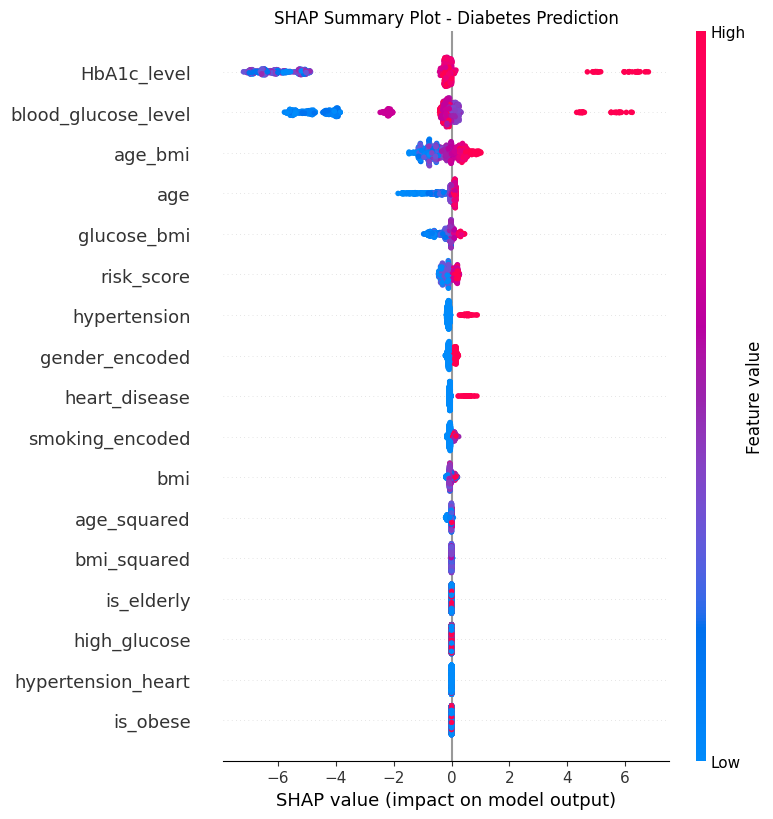

In [16]:
# Summary plot - shows feature importance with direction
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title("SHAP Summary Plot - Diabetes Prediction")
plt.tight_layout()
plt.show()

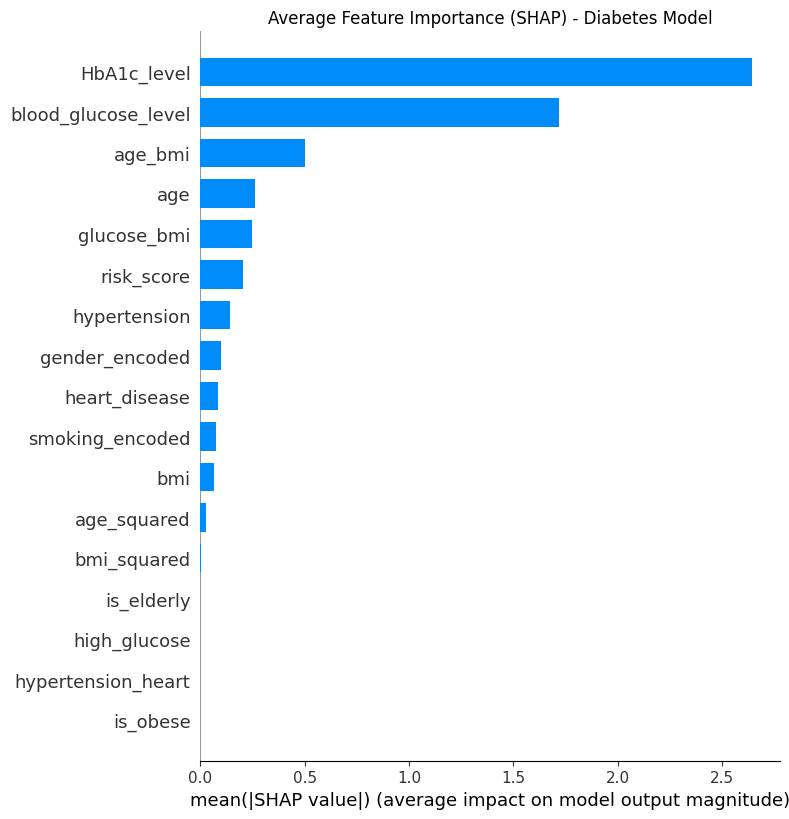

In [17]:
# Bar plot - average absolute SHAP value for each feature
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title("Average Feature Importance (SHAP) - Diabetes Model")
plt.tight_layout()
plt.show()

High Risk Patient: 100.0% diabetes risk
Low Risk Patient: 0.0% diabetes risk


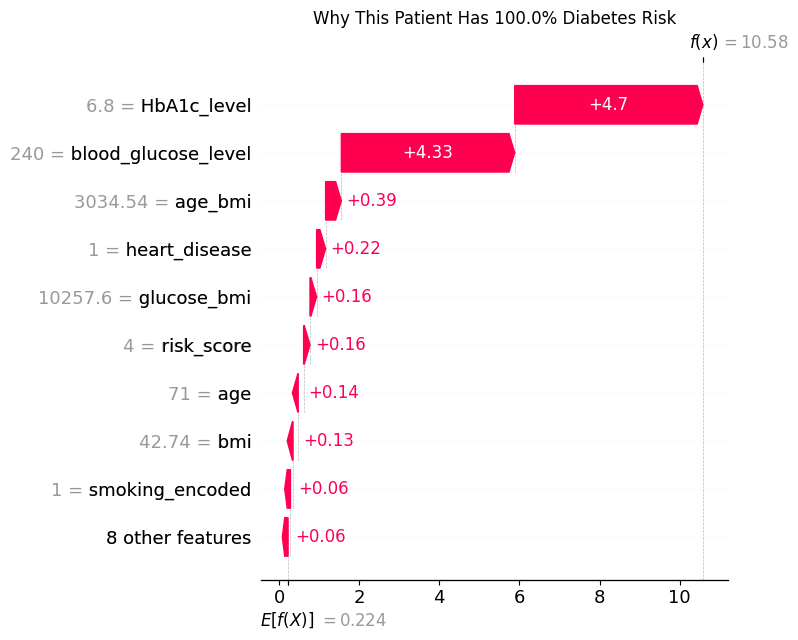

In [18]:
# Find a high-risk and low-risk patient from our sample
y_proba_sample = best_model.predict_proba(X_test_sample)[:, 1]

high_risk_idx = y_proba_sample.argmax()
low_risk_idx = y_proba_sample.argmin()

print(f"High Risk Patient: {y_proba_sample[high_risk_idx]*100:.1f}% diabetes risk")
print(f"Low Risk Patient: {y_proba_sample[low_risk_idx]*100:.1f}% diabetes risk")

# Waterfall for high-risk patient
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap.Explanation(
    values=shap_values[high_risk_idx],
    base_values=explainer.expected_value,
    data=X_test_sample.iloc[high_risk_idx],
    feature_names=X_test_sample.columns.tolist()
), show=False)
plt.title(f"Why This Patient Has {y_proba_sample[high_risk_idx]*100:.1f}% Diabetes Risk")
plt.tight_layout()
plt.show()

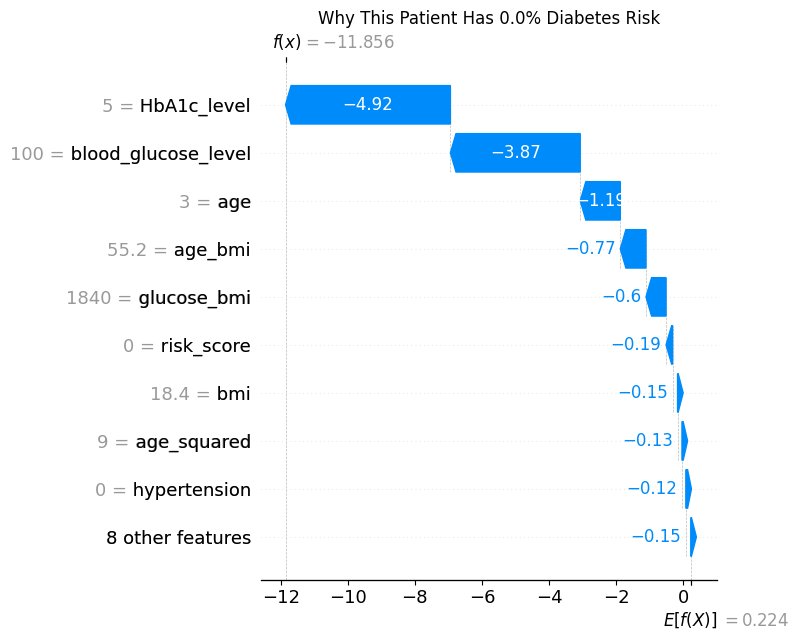

In [19]:
# Waterfall for low-risk patient
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap.Explanation(
    values=shap_values[low_risk_idx],
    base_values=explainer.expected_value,
    data=X_test_sample.iloc[low_risk_idx],
    feature_names=X_test_sample.columns.tolist()
), show=False)
plt.title(f"Why This Patient Has {y_proba_sample[low_risk_idx]*100:.1f}% Diabetes Risk")
plt.tight_layout()
plt.show()

Most important feature: HbA1c_level


<Figure size 1000x600 with 0 Axes>

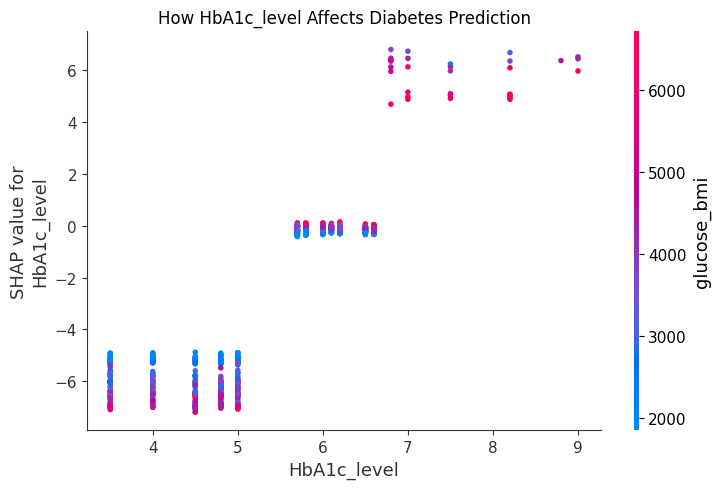

In [20]:
# Find most important feature
mean_shap = np.abs(shap_values).mean(axis=0)
most_important_idx = mean_shap.argmax()
most_important_feature = X_test_sample.columns[most_important_idx]

print(f"Most important feature: {most_important_feature}")

# Dependence plot
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    most_important_feature,
    shap_values,
    X_test_sample,
    show=False
)
plt.title(f"How {most_important_feature} Affects Diabetes Prediction")
plt.tight_layout()
plt.show()

In [21]:
# Save the best model
joblib.dump(best_model, '../models/diabetes_xgboost.pkl')
print("✅ Model saved to: models/diabetes_xgboost.pkl")

# Save the feature list
feature_list = X_train.columns.tolist()
with open('../models/diabetes_features.json', 'w') as f:
    json.dump(feature_list, f)
print("✅ Feature list saved to: models/diabetes_features.json")

# Final Summary
print("\n" + "="*50)
print("🎉 DIABETES MODEL - COMPLETE!")
print("="*50)

print("\n📊 MODEL PERFORMANCE:")
print(f"   ROC-AUC: 0.9796 (Excellent!)")
print(f"   Accuracy: 88.92%")
print(f"   Diabetes Caught: 94.1% (1,599 / 1,700)")
print(f"   Diabetes Missed: Only 101 patients")
print(f"   Features used: {len(feature_list)}")

print("\n🔧 TECHNIQUES USED:")
print("   1. Feature Engineering (17 features)")
print("   2. XGBoost with Class Balancing")
print("   3. Optuna Hyperparameter Tuning")
print("   4. Threshold Analysis")
print("   5. SHAP Explainability")

print("\n📁 FILES SAVED:")
print("   - models/diabetes_xgboost.pkl (trained model)")
print("   - models/diabetes_features.json (feature list)")

print("\n✅ Ready for deployment!")

✅ Model saved to: models/diabetes_xgboost.pkl
✅ Feature list saved to: models/diabetes_features.json

🎉 DIABETES MODEL - COMPLETE!

📊 MODEL PERFORMANCE:
   ROC-AUC: 0.9796 (Excellent!)
   Accuracy: 88.92%
   Diabetes Caught: 94.1% (1,599 / 1,700)
   Diabetes Missed: Only 101 patients
   Features used: 17

🔧 TECHNIQUES USED:
   1. Feature Engineering (17 features)
   2. XGBoost with Class Balancing
   3. Optuna Hyperparameter Tuning
   4. Threshold Analysis
   5. SHAP Explainability

📁 FILES SAVED:
   - models/diabetes_xgboost.pkl (trained model)
   - models/diabetes_features.json (feature list)

✅ Ready for deployment!
